In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs 
from sklearn.tree import DecisionTreeClassifier, export_text

In [65]:
# make data
X, y = make_blobs(
    n_samples=100,
    n_features=2,
    centers=4,
    cluster_std=[1, 2, 1, 3],
    random_state=42,
)

# Make it binary
y = [val % 2 for val in y]

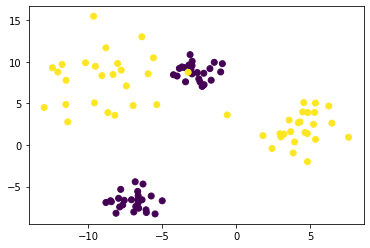

In [66]:
fig, ax = plt.subplots(1)

ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y
)

plt.show()

In [67]:
DEPTH = 3

model = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
model.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [68]:
tree_rules = export_text(model, feature_names=['x0', 'x1'])
print(tree_rules)

|--- x0 <= -0.76
|   |--- x0 <= -8.80
|   |   |--- class: 1
|   |--- x0 >  -8.80
|   |   |--- x1 <= -0.42
|   |   |   |--- class: 0
|   |   |--- x1 >  -0.42
|   |   |   |--- class: 0
|--- x0 >  -0.76
|   |--- class: 1



In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [70]:
clf = model

In [71]:
# Gathering relevant methods
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

# Determening tree structure
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

tree_dict = {}
tree_dict['depth'] = 5
tree_dict['nodes'] = [{} for _ in range(n_nodes)]

for i in range(n_nodes):
    if is_leaves[i]:
        print(f'leaf {i}')
        tree_dict['nodes'][i]['is_leaf'] = 1
        tree_dict['nodes'][i]['depth'] = node_depth[i]
        tree_dict['nodes'][i]['index'] = i
    else:
        tree_dict['nodes'][i]['is_leaf'] = 0
        tree_dict['nodes'][i]['depth'] = node_depth[i]
        tree_dict['nodes'][i]['index'] = i
        tree_dict['nodes'][i]['left'] = children_left[i]
        tree_dict['nodes'][i]['right'] = children_right[i]
        tree_dict['nodes'][i]['feature'] = feature[i]
        tree_dict['nodes'][i]['threshold'] = threshold[i]
        
    tree_dict['nodes'][i]['population'] = []

leaf 2
leaf 4
leaf 5
leaf 6


In [72]:
tree_dict['links'] = []

x_min = X[0:].min()
x_max = X[0:].max()
y_min = X[1:].min()
y_max = X[1:].max()

# Global collection of hyperplanes
tree_dict['hyperplanes'] = []

def get_coordinates(i, pos_x, pos_y, hyperplanes):
    '''DOCSTRING'''
    pos_y = tree_dict['nodes'][i]['depth'] * 10
    
    tree_dict['nodes'][i]['pos_x'] = pos_x
    tree_dict['nodes'][i]['pos_y'] = pos_y
    tree_dict['nodes'][i]['hyperplanes'] = hyperplanes
    
    if tree_dict['nodes'][i]['is_leaf'] == 1:
        return
    
    thresh = tree_dict['nodes'][i]['threshold']
    
    # Calculates current hyperplane
    current_hyperplane = {}
    if tree_dict['nodes'][i]['feature'] == 0:
        current_hyperplane['x1'] = thresh
        current_hyperplane['x2'] = thresh
        
        current_hyperplane['y1'] = y_min
        current_hyperplane['y2'] = y_max
    else:
        current_hyperplane['x1'] = x_min
        current_hyperplane['x2'] = x_max
        
        current_hyperplane['y1'] = thresh
        current_hyperplane['y2'] = thresh
    tree_dict['nodes'][i]['hyperplanes'].append(current_hyperplane)
    tree_dict['hyperplanes'].append(current_hyperplane)
    
    # Save left link
    tree_dict['links'].append({})
    tree_dict['links'][-1]['x1'] = pos_x
    tree_dict['links'][-1]['y1'] = pos_y
    tree_dict['links'][-1]['x2'] = pos_x + 10 + (2 * depth)
    tree_dict['links'][-1]['y2'] = pos_y + 10
    
    # Save right link
    tree_dict['links'].append({})
    tree_dict['links'][-1]['x1'] = pos_x
    tree_dict['links'][-1]['y1'] = pos_y
    tree_dict['links'][-1]['x2'] = pos_x - 10 - (2 * depth)
    tree_dict['links'][-1]['y2'] = pos_y + 10
    
    get_coordinates(
        tree_dict['nodes'][i]['left'],
        pos_x + 10 + (2 * depth),
        pos_y,
        tree_dict['nodes'][i]['hyperplanes'].copy()
    )
    
    get_coordinates(
        tree_dict['nodes'][i]['right'],
        pos_x - 10 - (2 * depth),
        pos_y,
        tree_dict['nodes'][i]['hyperplanes'].copy()
    )
    


In [73]:
get_coordinates(0, 0, 0, [])

In [74]:
tree_dict['nodes'][0]

{'is_leaf': 0,
 'depth': 0,
 'index': 0,
 'left': 1,
 'right': 6,
 'feature': 0,
 'threshold': -0.764798104763031,
 'population': [],
 'pos_x': 0,
 'pos_y': 0,
 'hyperplanes': [{'x1': -0.764798104763031,
   'x2': -0.764798104763031,
   'y1': -12.971335860507283,
   'y2': 15.48403041526756}]}

In [75]:
tree_dict['links']

[{'x1': 0, 'y1': 0, 'x2': 14, 'y2': 10},
 {'x1': 0, 'y1': 0, 'x2': -14, 'y2': 10},
 {'x1': 14, 'y1': 10, 'x2': 28, 'y2': 20},
 {'x1': 14, 'y1': 10, 'x2': 0, 'y2': 20},
 {'x1': 0, 'y1': 20, 'x2': 14, 'y2': 30},
 {'x1': 0, 'y1': 20, 'x2': -14, 'y2': 30}]

In [76]:
tree_dict['hyperplanes']

[{'x1': -0.764798104763031,
  'x2': -0.764798104763031,
  'y1': -12.971335860507283,
  'y2': 15.48403041526756},
 {'x1': -8.7988600730896,
  'x2': -8.7988600730896,
  'y1': -12.971335860507283,
  'y2': 15.48403041526756},
 {'x1': -12.971335860507283,
  'x2': 15.48403041526756,
  'y1': -0.4152803421020508,
  'y2': -0.4152803421020508}]

In [77]:
node_indicator = clf.decision_path(X)
leaf_id = clf.apply(X)

In [78]:
sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

In [79]:
node_index

array([0, 1, 2], dtype=int32)

In [80]:
print('Rules used to predict sample {id}:\n'.format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        print(f'leaf {node_id}')
        continue

    # check if value of the split feature for sample 0 is below threshold
    if (X[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision node {node} : (X[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature[node_id],
              value=X[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id]))


Rules used to predict sample 0:

decision node 0 : (X[0, 0] = -11.378708910841226) <= -0.764798104763031)
decision node 1 : (X[0, 0] = -11.378708910841226) <= -8.7988600730896)
leaf 2


In [81]:
for sample_id in range(len(X)):
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]
    for node_id in node_index:
        tree_dict['nodes'][node_id]['population'].append(sample_id)

In [82]:
y_pred = model.predict(X)

In [83]:

df = pd.DataFrame(
        zip(X[:, 0], X[:, 1], y, y_pred),
        columns=['x0', 'x1', 'y', 'pred']
)
df['index'] = df.index
df.to_csv('example_data.csv', index=False, header=True)


In [84]:
tree_dict['data'] = df.to_dict('records')

In [85]:
import json

# https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable/50916741
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)
        
with open('tree.json', 'w') as fp:
    json.dump(tree_dict, fp, cls=NpEncoder)

In [86]:
for i in range(n_nodes):
    print(tree_dict['nodes'][i]['pos_y'])

0
10
20
20
30
30
10


In [87]:
n_nodes

7

In [88]:
len(tree_dict['nodes'])

7

In [89]:
for i in range(n_nodes):
    print(tree_dict['nodes'][i]['pos_x'])

0
14
28
0
14
-14
-14


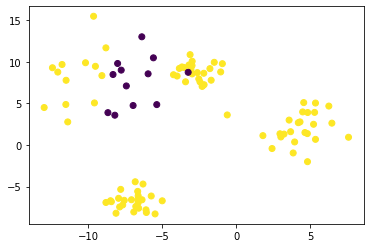

In [90]:
df['correct'] = (df['y'] == df['pred'])

fig, ax = plt.subplots(1)

ax.scatter(
    df['x0'],
    df['x1'],
    c=df['correct']
)

plt.show()

In [91]:
df.correct.sum() / len(df)

0.88